In [64]:
# imports

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import gc
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import warnings
warnings.filterwarnings('ignore')

random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.manual_seed(30)
torch.cuda.manual_seed(30)

In [65]:
DEVICE

'cuda'

In [86]:
df = pd.read_csv('dataset/processed_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Price,Anuradhapura_Producer_Price,Kurunegala_Producer_Price,Polonnaruwa_Producer_Price,Producer_Price,Production,Production_Total,Exchange_Rate,Fuel_Price
0,1996-01-01,18.07,7.75,7.900,8.18,8.18,1333.600,2065.100,53.685,12.4
1,1996-02-01,18.70,8.17,8.260,8.76,8.76,1333.600,2065.100,53.685,12.4
2,1996-03-01,18.49,7.95,7.850,7.99,7.99,1333.600,2065.100,53.685,12.4
3,1996-04-01,18.52,8.25,8.010,8.29,8.29,1333.600,2065.100,54.735,12.4
4,1996-05-01,19.02,8.38,8.500,8.34,8.34,731.500,2065.100,54.950,12.4
...,...,...,...,...,...,...,...,...,...,...
319,2022-08-01,239.24,112.60,113.863,122.93,122.93,1461.675,3392.875,357.880,430.0
320,2022-09-01,228.44,110.50,108.008,117.00,117.00,1461.675,3392.875,365.500,430.0
321,2022-10-01,224.78,110.50,108.008,117.00,117.00,1931.200,3392.875,363.000,430.0
322,2022-11-01,224.78,110.50,108.008,117.00,117.00,1931.200,3392.875,368.500,430.0


In [87]:
combined_series = pd.concat([df['Price'], df['Producer_Price'],
                             df['Exchange_Rate']]).reset_index(drop=True)

combined_series.name = 'value'
combined_series = pd.DataFrame(combined_series)
combined_series

,value
0,18.07
1,18.70
2,18.49
3,18.52
4,19.02
...,...
967,357.88
968,365.50
969,363.00
970,368.50


In [88]:
combined_series['date'] = pd.concat([df['Date'], df['Date'], df['Date']]).reset_index(drop=True)
combined_series

,value,date
0,18.07,1996-01-01
1,18.70,1996-02-01
2,18.49,1996-03-01
3,18.52,1996-04-01
4,19.02,1996-05-01
...,...,...
967,357.88,2022-08-01
968,365.50,2022-09-01
969,363.00,2022-10-01
970,368.50,2022-11-01


In [89]:
combined_series.shape[0]

972

In [90]:
series_arr = np.array([['0', '1', '2']])
combined_series['series'] = np.repeat(series_arr, combined_series.shape[0]/3)
combined_series

,value,date,series
0,18.07,1996-01-01,0
1,18.70,1996-02-01,0
2,18.49,1996-03-01,0
3,18.52,1996-04-01,0
4,19.02,1996-05-01,0
...,...,...,...
967,357.88,2022-08-01,2
968,365.50,2022-09-01,2
969,363.00,2022-10-01,2
970,368.50,2022-11-01,2


In [91]:
combined_series = (combined_series.merge((combined_series[['date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['date']))
combined_series['month'] = combined_series['date'].dt.month
combined_series['year'] = combined_series['date'].dt.year
combined_series

,value,date,series,time_idx,month,year
0,18.070,1996-01-01,0,0,1,1996
1,8.180,1996-01-01,1,0,1,1996
2,53.685,1996-01-01,2,0,1,1996
3,18.700,1996-02-01,0,1,2,1996
4,8.760,1996-02-01,1,1,2,1996
...,...,...,...,...,...,...
967,117.000,2022-11-01,1,322,11,2022
968,368.500,2022-11-01,2,322,11,2022
969,224.780,2022-12-01,0,323,12,2022
970,117.000,2022-12-01,1,323,12,2022


In [92]:
combined_series.shape[0]

972

In [93]:
train = combined_series[(combined_series["date"] >= pd.to_datetime("2012-01-01")) & (combined_series["date"] < pd.to_datetime("2019-12-01"))]

max_prediction_length = 12
max_encoder_length = train.date.nunique()
training_cutoff = train["time_idx"].max() - max_prediction_length

print(max_encoder_length)
print(training_cutoff)

95
274


In [94]:
train

,value,date,series,time_idx,month,year
576,61.54,2012-01-01,0,192,1,2012
577,28.74,2012-01-01,1,192,1,2012
578,113.85,2012-01-01,2,192,1,2012
579,59.53,2012-02-01,0,193,2,2012
580,22.90,2012-02-01,1,193,2,2012
...,...,...,...,...,...,...
856,51.31,2019-10-01,1,285,10,2019
857,181.05,2019-10-01,2,285,10,2019
858,99.21,2019-11-01,0,286,11,2019
859,51.48,2019-11-01,1,286,11,2019


In [95]:
# Let's create a Dataset
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=['series'], 
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['series'],
#     time_varying_known_reals=["month"],
    time_varying_unknown_reals=["value"],
    target_normalizer=GroupNormalizer(
        groups=['series'], transformation="softplus"
    ),  # use softplus and normalize by group
    categorical_encoders={"series": NaNLabelEncoder().fit(combined_series.series)},
#     lags={'value': [3, 6, 12]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True, 
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [96]:
#let's see how a naive model does

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

3.4865288734436035

In [97]:
sm = SMAPE()
print(f"Median loss for naive prediction on validation: {sm.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

Median loss for naive prediction on validation: 0.02951492927968502


In [98]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:40:05_Pacific_Daylight_Time_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0


In [99]:
torch.cuda.is_available()

True

In [100]:
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.0.0+cu118
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:40:05_Pacific_Daylight_Time_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 2060 SUPER


In [104]:
# # configure network and trainer
# early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
# lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
#
# trainer = pl.Trainer(
#     max_epochs=30,
#     accelerator='gpu',
#     devices=1,
#     enable_model_summary=True,
#     gradient_clip_val=0.1,
#     limit_train_batches=30,  # coment in for training, running valiation every 30 batches
#     # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
#     callbacks=[lr_logger, early_stop_callback],
#     logger=logger,
# )
#
#
# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.03,
#     hidden_size=16,
#     attention_head_size=1,
#     dropout=0.1,
#     hidden_continuous_size=8,
#     output_size=7,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
#     reduce_on_plateau_patience=4,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 17.7k


In [109]:
PATIENCE = 30
MAX_EPOCHS = 120
LEARNING_RATE = 0.03
OPTUNA = False

In [110]:
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=1,
    devices=1,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.25,
    limit_train_batches=10,  # coment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=SMAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)

tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 21.7k


In [111]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | SMAPE                           | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 9     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [108]:
import pickle

# create a study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)

In [112]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader, mode="prediction")
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

sm = SMAPE()
print(f"Validation median SMAPE loss: {sm.loss(actuals, predictions).mean(axis = 1).median().item()}")

Validation median SMAPE loss: 0.12479978054761887


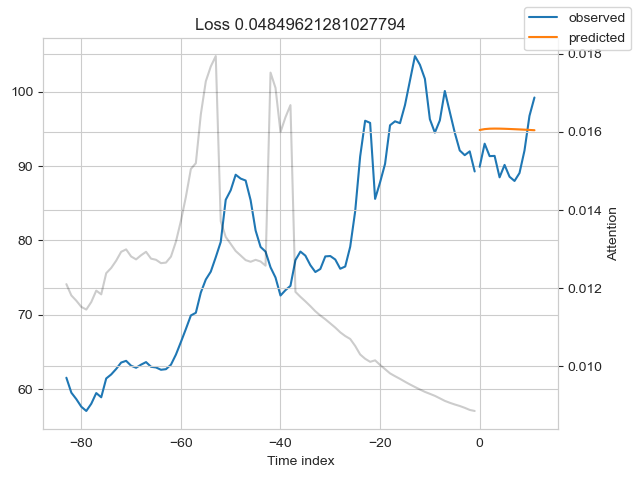

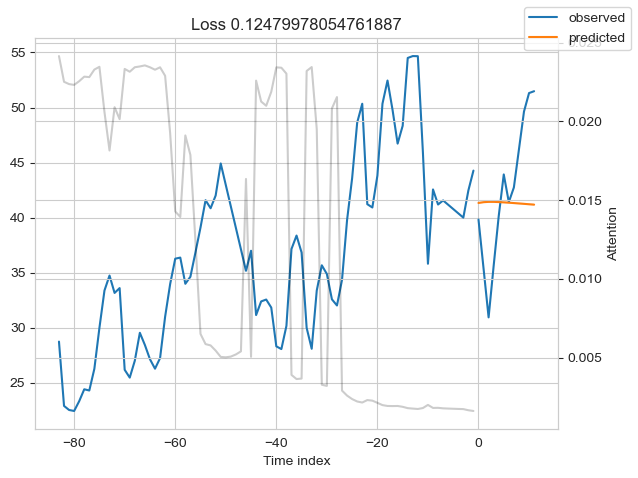

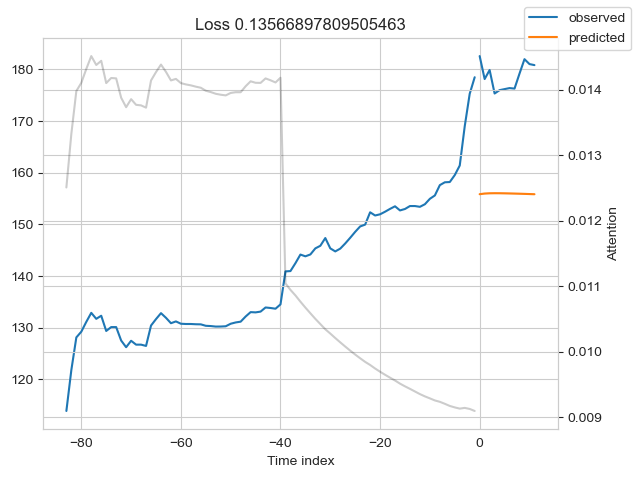

In [113]:
for idx in range(3):  # plot 10 examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
raw_predictions[0]

# Actuals
# 89
# 90
# 93

In [29]:
train.tail(12*4)

,value,date,series,time_idx,month,year
1056,101.720000,2018-01-01,0,264,1,2018
1057,45.950000,2018-01-01,1,264,1,2018
1058,153.900000,2018-01-01,2,264,1,2018
1059,95.000000,2018-01-01,3,264,1,2018
1060,96.290000,2018-02-01,0,265,2,2018
1061,35.810000,2018-02-01,1,265,2,2018
1062,154.950000,2018-02-01,2,265,2,2018
1063,95.000000,2018-02-01,3,265,2,2018
1064,94.490000,2018-03-01,0,266,3,2018
1065,42.560000,2018-03-01,1,266,3,2018


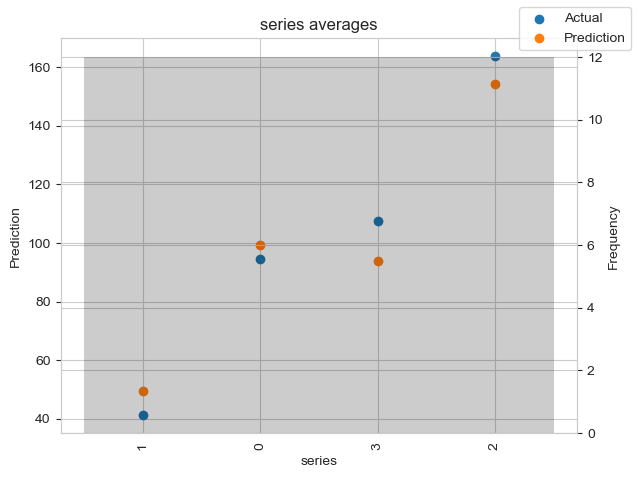

In [30]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name='series');

## TFT with Hyperparameters

In [116]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val= 0.5337363385071636,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
    hidden_size= 84,
    dropout= 0.28980690557138233,
    hidden_continuous_size= 31,
    attention_head_size= 1,
    learning_rate= 0.01196313233856177,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 414.1k


In [117]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 9     
3  | prescalers                         | ModuleDict                      | 310   
4  | static_variable_selection          | VariableSelectionNetwork        | 24.2 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 16.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 28.7 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 28.7 K
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


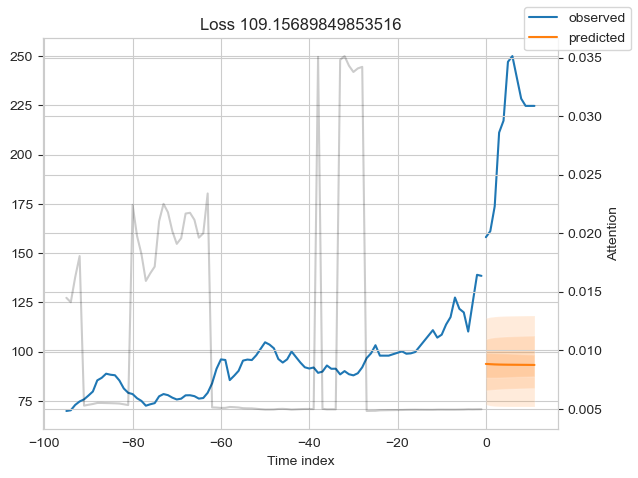

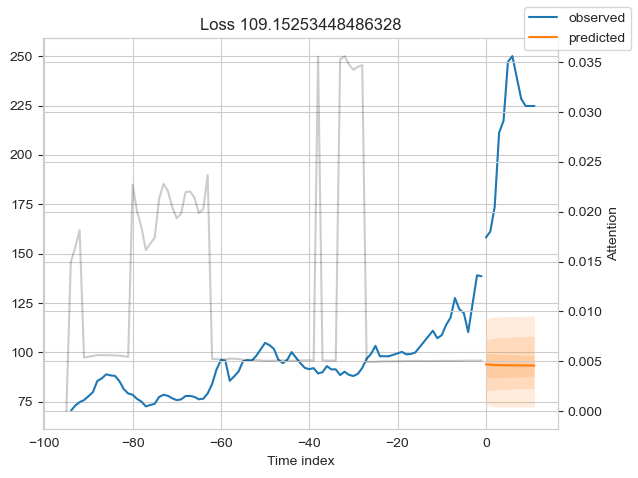

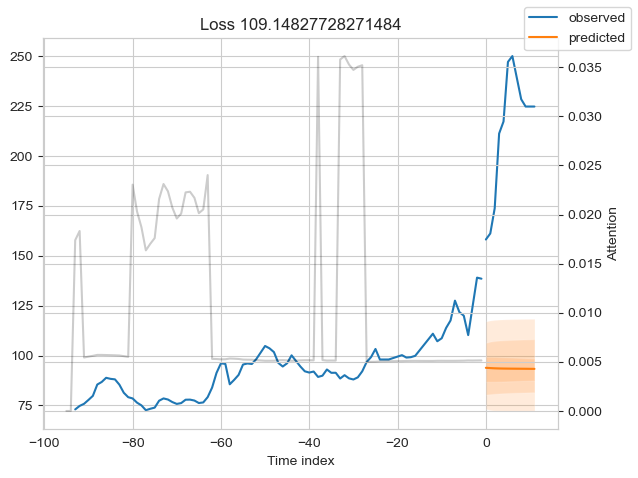

In [121]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(3):  # plot 10 examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [119]:
# create dataset and dataloaders
max_encoder_length = 12
max_prediction_length = 12

data = combined_series.copy()

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

# Let's create a Dataset
training_nhits = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=['series'],
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [122]:
from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    gpus=1,
    devices=1,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=0.09,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


AssertionError: only fixed encoder length is allowed, but min_encoder_length != max_encoder_length